In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_colwidth',200)
#显示所有列，把行显示设置成最大
pd.set_option('display.max_columns', None)
#显示所有行，把列显示设置成最大
pd.set_option('display.max_rows', None)

In [27]:
df = pd.read_excel('./第一部分数据机器学习用（剔除无差异指标）.xlsx')

In [28]:
df['label'] = df['组别']
df.drop('组别',axis=1,inplace=True)

In [29]:
df.head()

,Participant,指标1,指标5,指标6,指标7,指标8,指标9,指标10,指标11,指标12,指标13,指标14,指标15,指标16,指标17,指标18,指标19,指标20,label
0,A1,6.925000,136.807500,3.365000,1557.625000,480.266667,48.533333,3.133333,898.533333,55.433333,99.400000,0.075,162.116667,98.933333,12.866667,5350.450000,134.966667,305.283333,1
1,A2,3.948718,171.351282,5.782051,667.435897,716.600000,34.266667,7.733333,12739.566667,291.666667,417.233333,1.000,181.750000,94.100000,10.933333,7607.600000,139.783333,392.583333,1
2,A3,12.600000,71.377500,3.860000,2061.125000,520.350000,62.650000,10.350000,5318.550000,133.700000,253.250000,0.450,149.416667,95.516667,9.816667,5429.700000,103.550000,308.050000,1
3,A4,10.351351,60.081081,2.994595,861.405405,577.233333,55.566667,4.166667,1679.700000,66.166667,134.766667,0.475,233.300000,71.700000,7.400000,4585.783333,107.316667,241.283333,1
4,A5,9.257143,115.180000,4.520000,1563.028571,647.533333,48.533333,2.600000,1098.666667,55.000000,112.866667,0.575,112.100000,69.766667,11.133333,9849.150000,159.900000,360.233333,1


## 正负样本比例

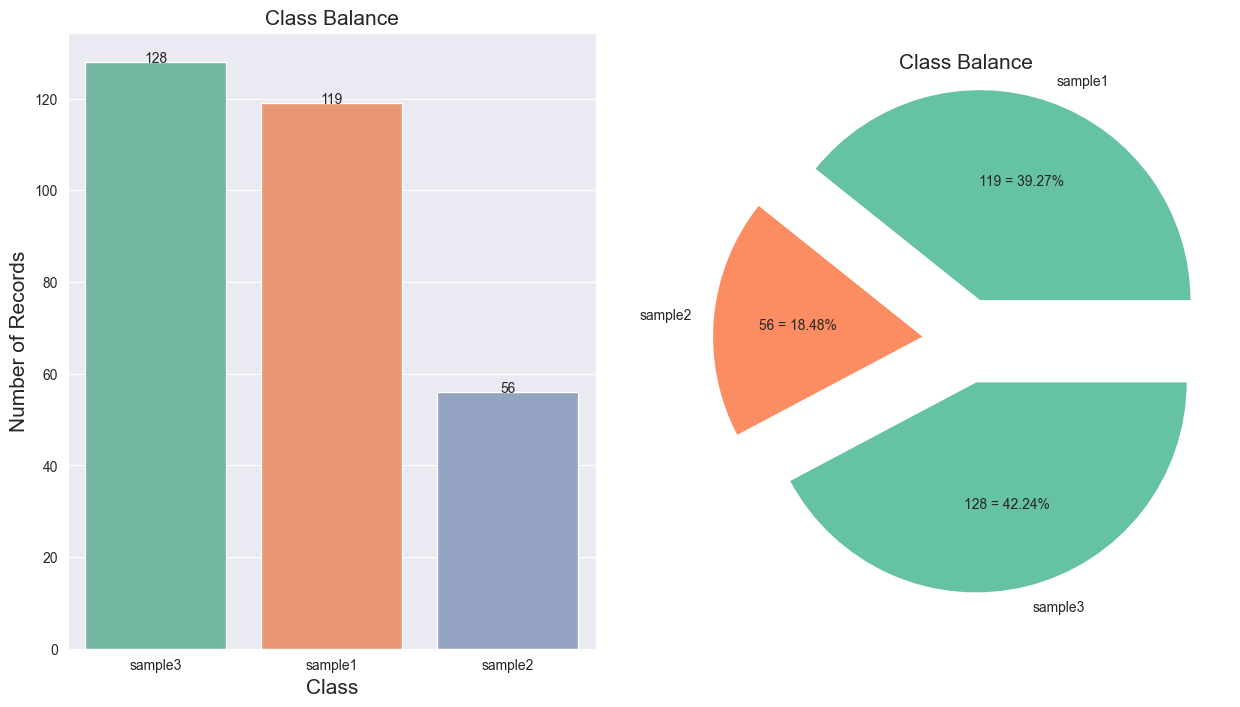

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.set_style('darkgrid')
sns.set_palette('Set2')

counts = pd.DataFrame(df["label"].value_counts()).rename(index={1: "sample1", 2: "sample2",3:'sample3'})
_ = sns.barplot(x=counts.index, y=counts.label, ax=axs[0])
for p in axs[0].patches:
    axs[0].text(x=p.get_x()+(p.get_width()/2), y=p.get_height(), s="{:,d}".format(round(p.get_height())), ha="center")
_ = axs[0].set_title("Class Balance", fontsize=15)
_ = axs[0].set_ylabel("Number of Records", fontsize=15)
_ = axs[0].set_xlabel("Class", fontsize=15)

data = [
    df[(df["label"] == 1)]["Participant"].count(),
    df[(df["label"] == 2)]["Participant"].count(),
    df[(df["label"] == 3)]["Participant"].count()
]
_ = axs[1].pie(
    data, labels=["sample1", "sample2",'sample3'],
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
    explode=[0.20] * 3, 
    colors=sns.color_palette("Set2")[0:2],
)
_ = axs[1].set_title("Class Balance", fontsize=15)

## 空缺值检测

In [31]:
#============= 缺失率 ================  
#行缺失
def idx_missing(data,features):
    total=data[features].isnull().sum(axis=1).sort_values(ascending=False)
    percent=total/len(features)
    missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
    return missing_data
# 列缺失
def col_missing(data,features):
    total=data[features].isnull().sum().sort_values(ascending=False)
    percent=total/len(data)
    missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
    return missing_data

In [32]:
features = df.columns.to_list()
# 行缺失处理
idx_missing_data=idx_missing(df,features)
idx_miss_drop=idx_missing_data[idx_missing_data.Percent>0.7].index.to_list()
print('行缺失率大于70%的行index为：====》{0}'.format(idx_miss_drop))
df = df.drop(idx_miss_drop,axis=0)
#列缺失和唯一值处理
# col_missing_data=col_missing(df,num_fea+cat_fea)
col_missing_data=col_missing(df,features)
miss_drop=col_missing_data[col_missing_data.Percent>0.80].index.to_list()
print('列缺失率大于80%的列columns为：====》{0}'.format(miss_drop))

行缺失率大于70%的行index为：====》[]
列缺失率大于80%的列columns为：====》[]


## 缺失值可视化

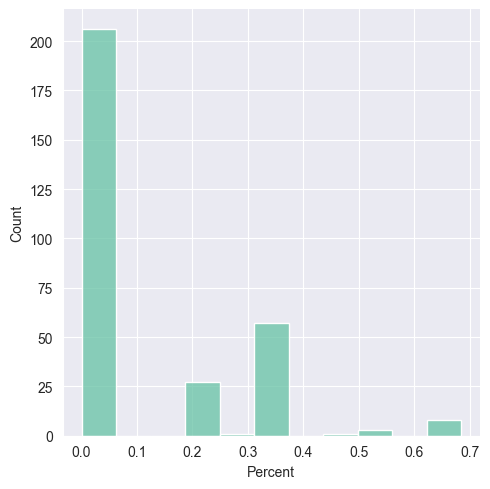

In [33]:
sns.displot(idx_missing_data, x="Percent")
plt.show()

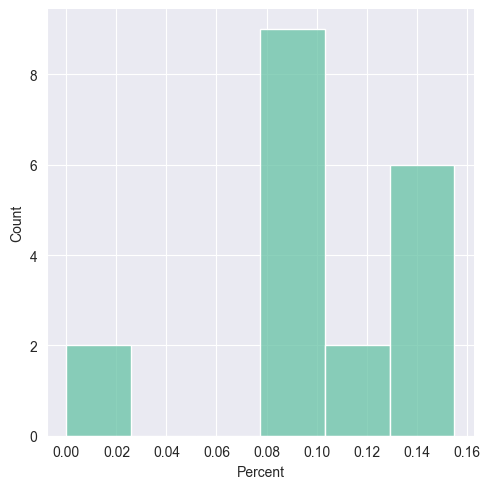

In [34]:
sns.displot(col_missing_data, x="Percent")
plt.show()

## 空缺值填充

In [35]:
#找出类别型特征名
cat_fea=df.dtypes[df.dtypes=='object'].index.to_list()
#找出数值型特征名
num_fea=df.dtypes[df.dtypes!='object'].index.to_list()
num_fea.remove('label')
# 众数统计
mod_dic = df[cat_fea].mode(dropna=True).iloc[0,:].to_dict()
num_dic = df[num_fea].median(skipna=True).to_dict()
df.loc[:,num_fea] = df.loc[:,num_fea].fillna(value=num_dic)
df.loc[:,cat_fea] = df.loc[:,cat_fea].fillna(value=mod_dic)
df.dropna(how='any',inplace=True)

## 时间特征衍生

In [36]:
def func(data,flag):
    weekday = data['AlarmTimeStamp'].dayofweek
    hour =  data['AlarmTimeStamp'].hour
    if flag=='weekend':
        if weekday > 4:
            return 'yes'
        else:
            return 'no'
    elif flag=='weekday':
        return weekday
    else:
        if (hour > 6) &(hour < 12):
            return 'am'
        elif hour < 18:
            return 'pm'
        else:
            return 'night'  

source_col = ['AlarmTimeStamp','ParameterTimeStamp','RecordTimeStamp']
ins_col = ['weekend','weekday','amOrpmOrnight']
time_fea_tag = False
if time_fea_tag:
    for tmp_source_col in source_col:
        df[tmp_source_col] = pd.to_datetime(df[tmp_source_col],format='%Y-%m-%d %H:%M:%S')
        for tmp_ins_col in ins_col:
            dst_col = tmp_source_col+'_'+tmp_ins_col
            df[dst_col] = df.apply(func,args=(tmp_ins_col,),axis=1)
    df.drop(source_col,axis=1,inplace=True)

## 常变量检测

In [37]:
#  * unique过滤
def uni(data,features):
    temp=[data[item].nunique()  for item in features]
    feature_unique=pd.DataFrame()
    feature_unique['feature_name']=features
    feature_unique['unique']=temp
    feature_unique=feature_unique.sort_values(by='unique',ascending=False)
    return feature_unique

# 剔除单个特征值占比较高的特征
def ferq(data,features):
    temp = list()
    for var1 in features:
        if data[var1].value_counts(dropna=False, normalize=True).max() > 0.90:
            temp.append(var1)
    return temp
# 标准差过滤
def std_fea(data,feature):
    temp = data[feature].describe()
    temp = temp.transpose()
    temp.reset_index(inplace=True)
    temp.rename(columns={'index':'feature_name'},inplace=True)
    temp = temp[['feature_name','std']]
    temp.sort_values(by='std',ascending=True,inplace=True)
    return temp

In [38]:
#找出类别型特征名
cat_fea=df.dtypes[df.dtypes=='object'].index.to_list()
#找出数值型特征名
num_fea=df.dtypes[df.dtypes!='object'].index.to_list()
all_fea = df.columns.to_list()
all_fea.remove('label')
num_fea.remove('label')
# 唯一值筛查
feature_unique=uni(df,cat_fea)
unique_drop=feature_unique.loc[feature_unique['unique']==1,'feature_name'].to_list()
print('特征值唯一的列columns为：====》{0}'.format(unique_drop))
# 特征值占比筛选
frep_drop=ferq(df,all_fea)
print('单特征值占比超过95%列columns为：====》{0}'.format(frep_drop))
# 均方差筛查
feature_std=std_fea(df,num_fea)
std_fea_drop=feature_std[feature_std['std'] < 0.10]['feature_name'].to_list()
print('标准差小于10%的特征为：====》{0}'.format(std_fea_drop))

特征值唯一的列columns为：====》[]
单特征值占比超过95%列columns为：====》[]
标准差小于10%的特征为：====》[]


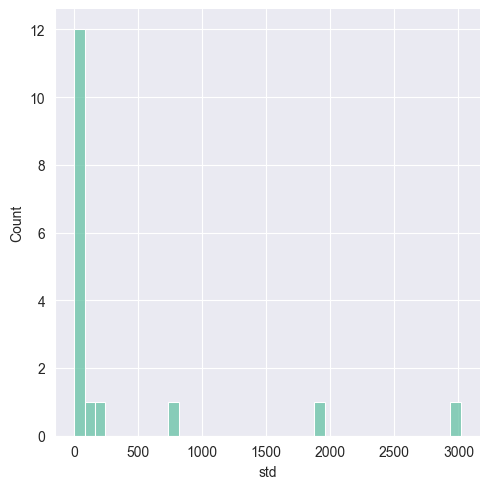

In [39]:
sns.displot(feature_std, x="std")
plt.show()

## psi检验特征稳定性

In [40]:
frac = 0.7
samp_size = int(df.shape[0]*frac)
data_train = df.iloc[:samp_size,:]
data_oot = df.iloc[samp_size:,:]

In [41]:
#======= psi检查 =============
def psi_categ(actual, expected):
    '''
    :param actual: 类别型变量
    :param expected:
    :return:
    '''
    acnt = actual.value_counts()
    ecnt = expected.value_counts()
    arate = actual.value_counts() / len(actual)
    erate = expected.value_counts() / len(expected)

    psi = np.sum((arate - erate) * np.log(arate / erate))

    return psi

def psi_contins(actual, expected, quant=10):
    '''
    :param actual: 连续型变量
    :param expected:
    :param quant:
    :return:
    '''
    minv = min(min(actual), min(expected))
    maxv = max(max(actual), max(expected))
    step = 1.0 * (maxv - minv) / quant
    acnt = []
    ecnt = []
    s, e = minv, minv + step
    act = np.array(actual)
    ex = np.array(expected)

    while e <= maxv and step != 0:
        acnt.append(((act >= s) & (act < e)).sum())
        ecnt.append(((ex >= s) & (ex < e)).sum())
        s = e
        e = e + step

    arate = np.array(acnt) / len(actual)
    erate = np.array(ecnt) / len(expected)

    arate[arate == 0] = 0.000001
    erate[erate == 0] = 0.000001

    psi = np.sum((arate - erate) * np.log(arate / erate))

    return psi

#找出类别型特征名
cat_fea=df.dtypes[df.dtypes=='object'].index.to_list()
#找出数值型特征名
num_fea=df.dtypes[df.dtypes!='object'].index.to_list()
num_fea.remove('label')

col_categorical = []
col_categorical_psi = []

for col in cat_fea:
    col_categorical.append(col)
    col_categorical_psi.append(psi_categ(data_train[col], data_oot[col]))
    
for col in num_fea:
    col_categorical.append(col)
    col_categorical_psi.append(psi_contins(data_train[col], data_oot[col]))

psi_df_category = pd.DataFrame()
psi_df_category['index'] = col_categorical
psi_df_category['psi'] = col_categorical_psi
#psi_df_category.to_csv(r'F:\9f\ouput_data\data_monthly_rs_psi_categorical_var_part1_part2.csv', index=False)
psi_high_var_cat = psi_df_category[psi_df_category['psi'] >=0.25]['index'].tolist()
print('由于psi值大于0.25需要删除的columns有{0}'.format(psi_high_var_cat))

由于psi值大于0.25需要删除的columns有['指标1', '指标5', '指标6', '指标7', '指标8', '指标9', '指标10', '指标11', '指标12', '指标13', '指标14', '指标15', '指标17', '指标18', '指标19', '指标20']


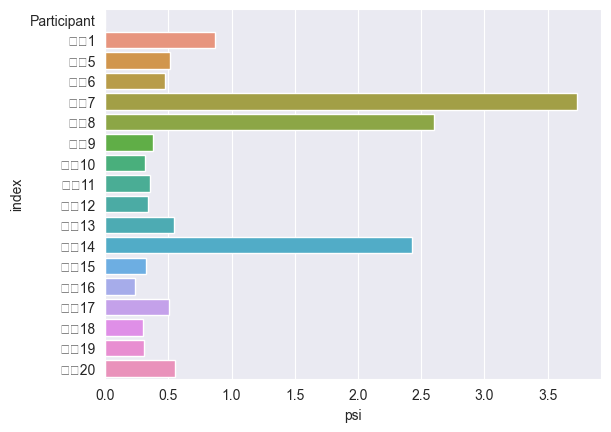

In [42]:
sns.barplot(psi_df_category, x="psi",y='index')
plt.show()

## woe-IV

In [15]:
import scorecardpy as sc

In [27]:
#找出类别型特征名
cat_fea=df.dtypes[df.dtypes=='object'].index.to_list()
num_fea=df.dtypes[df.dtypes!='object'].index.to_list()
tst = data_train[num_fea]
# Numeric Variables  连续变量iv计算
bins_adj = sc.woebin(tst,y='label')

bin_train_df = pd.DataFrame()
for i in bins_adj.keys():
    bin_train_df = pd.concat([bin_train_df,bins_adj[i]])

breaks_list = {}
for i in bins_adj.keys():
    bin_cut = [float(i.replace('[','').replace(')','').split(',')[0]) for i in bins_adj[i]['bin'].tolist() if i !='missing']
    bin_cut.append(np.inf)
    breaks_list[i]=bin_cut
    

bins_adj = sc.woebin(data_oot[num_fea],y='label', breaks_list=breaks_list)
bin_test_df = pd.DataFrame()
for i in bins_adj.keys():
    bin_test_df = pd.concat([bin_test_df,bins_adj[i]])
final_feature = list(set(bin_train_df[bin_train_df['total_iv']>0.02]['variable'])&set(bin_test_df[bin_test_df['total_iv']>0.02]['variable']))
print('最终保留的colunms有{0}'.format(final_feature))

[INFO] creating woe binning ...


TypeError: unhashable type: 'numpy.ndarray'

## 最终删除

In [24]:
to_drop=list(set(idx_miss_drop+miss_drop+unique_drop+std_fea_drop+frep_drop+psi_high_var_cat))
print('最终需要删除的列columns为：====》{0}'.format(to_drop))
df=df.drop(to_drop,axis=1) 

最终需要删除的列columns为：====》['指标8', '指标1', '指标19', '指标20', '指标14', '指标9', '指标6', '指标11', '指标13', '指标17', '指标18', '指标7', '指标12', '指标10', '指标15', '指标5']


## 特征数值化

In [43]:
from sklearn import preprocessing
cat_fea=df.dtypes[df.dtypes=='object'].index.to_list()
num_fea=df.dtypes[df.dtypes!='object'].index.to_list()
all_fea = df.columns.to_list()
all_fea.remove("label")

modle_cat = preprocessing.OrdinalEncoder()
df.loc[:,cat_fea] = modle_cat.fit_transform(df.loc[:,cat_fea])
modle_num = preprocessing.StandardScaler()
df[all_fea] = modle_num.fit_transform(df[all_fea])

modle_label = preprocessing.OrdinalEncoder()
df[['label']] = modle_label.fit_transform(df[['label']])

df = df.convert_dtypes()
df = df.astype('float32')

## 特征相关性热力图

<Axes: >

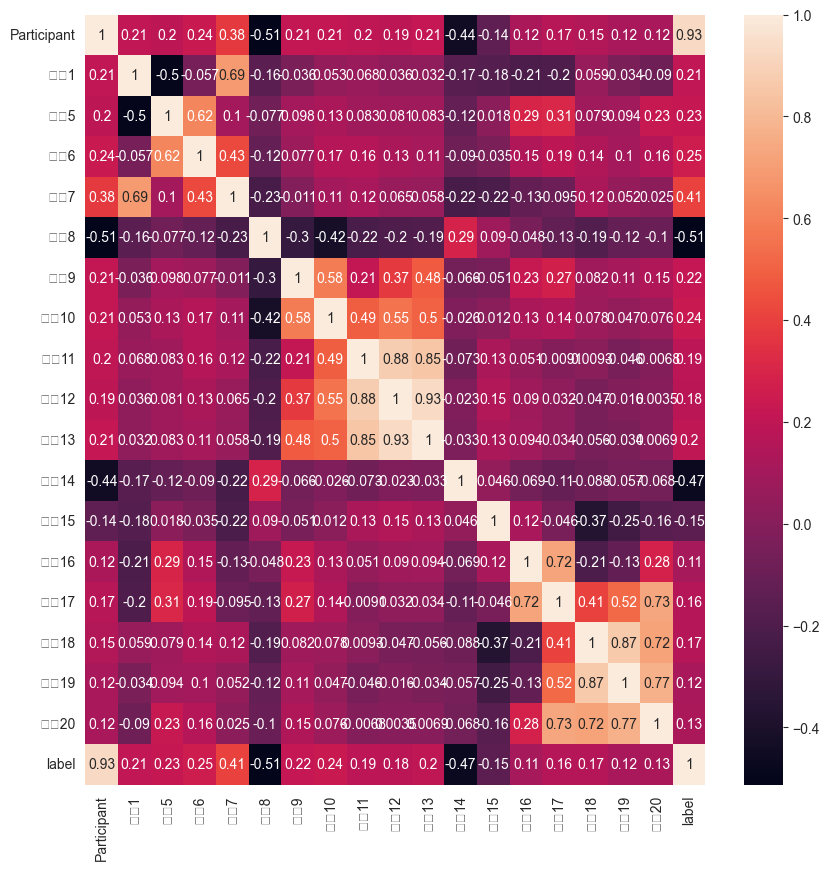

In [44]:
fea2target = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(fea2target,annot=True)

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 特征晒筛选

In [46]:
import lightgbm as lgb
num_class = len(df['label'].unique())
features = df.drop('label',axis=1)
label = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    features,
    label,
    test_size=0.2,
    random_state=1,
    
)
train_data=lgb.Dataset(X_train.values,label=y_train.values)
validation_data=lgb.Dataset(X_test.values,label=y_test.values)

params={
    'learning_rate':0.1,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':4,
    'objective':'multiclass',
    'num_class':num_class,
}
model=lgb.train(params,train_data,valid_sets=[validation_data])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 18
[LightGBM] [Info] Start training from score -0.903970
[LightGBM] [Info] Start training from score -1.682275
[LightGBM] [Info] Start training from score -0.893818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 0.861522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's multi_logloss: 0.72734
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's multi_logloss: 0.0204388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's multi_logloss: 0.0204265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's multi_logloss: 0.0203894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [47]:
from sklearn.metrics import roc_auc_score,accuracy_score
y_pred=model.predict(X_test)
y_pred=[list(x).index(max(x)) for x in y_pred]
print('lgb的acc为：',accuracy_score(y_test.astype('int').values,y_pred))

lgb的acc为： 0.9836065573770492


In [48]:
#确定最终所选特征数量
dst_fea_nb = 10
train_features = df.columns.to_list()
train_features.remove('label')
feature_importance             = pd.DataFrame()
feature_importance['fea_name'] = train_features
feature_importance['fea_imp']  = model.feature_importance()
feature_importance             = feature_importance.sort_values('fea_imp',ascending = False)

end_fea = feature_importance['fea_name'].values[:dst_fea_nb]
end_fea = list(end_fea)
print('最终留下的特征{}'.format(end_fea))
end_fea.append('label')

df_end = df[end_fea]

最终留下的特征['Participant', '指标18', '指标14', '指标20', '指标17', '指标9', '指标1', '指标5', '指标16', '指标7']


## smote采样

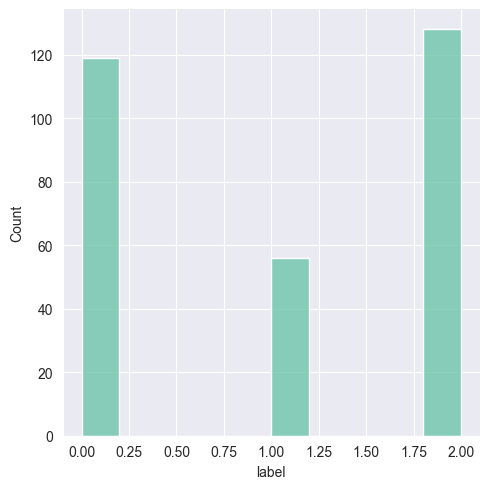

In [49]:
sns.displot(df_end, x="label")
plt.show()

In [50]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.combine import SMOTETomek

smote_tag = True
if smote_tag:
    sos = SMOTE(random_state=0)
    features, label = sos.fit_resample(df_end.drop('label',axis=1), df_end['label'])
else:
    features = df_end.drop('label',axis=1)
    label = df_end['label']

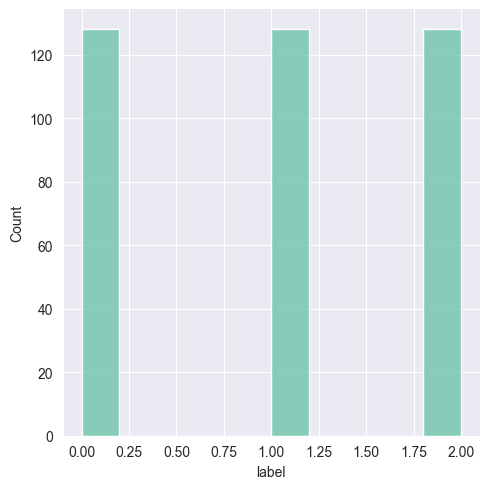

In [51]:
sns.displot(label)
plt.show()

## 数据集划分

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    label,
    test_size=0.2,
    random_state=1,
)

## 随机森林

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators':range(10,30,10)
          ,'criterion':['gini','entropy']
          ,'max_depth':range(3,10,3)
          ,'min_samples_split':range(10,30,10)
          ,'min_samples_leaf':range(5,40,10)
           }
model_rf = RandomForestClassifier()
gs_rf = GridSearchCV(estimator=model_rf,param_grid=params,cv=10,n_jobs=4)

gs_rf.fit(X_train, y_train.astype('int').values)
print('最好的参数设置为：')
print(gs_rf.best_params_)
brf = gs_rf.best_estimator_
brf = brf.fit(X_train,  y_train.astype('int'))

最好的参数设置为：
{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 20}


In [59]:
df.label.unique()

array([0., 1., 2.], dtype=float32)

In [66]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= brf.predict(X_test)


acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))    
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))    
precision = precision_score(y_test, y_pred,average='macro')
print('精确率为：{}'.format(precision))


Start predicting...
准确率为：1.0
召回率为：1.0
f1分数为：1.0
精确率为：1.0


## 逻辑回归

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

params = {'max_iter':range(100,1000,100) 
          ,'penalty':['l1','l2']
          ,'C': [0.01, 0.1, 1, 10]
           }
model_lr = LogisticRegression(multi_class="multinomial", solver="newton-cg", max_iter=1000)
gs_lr = GridSearchCV(estimator=model_lr,param_grid=params,cv=10,n_jobs=4)

gs_lr.fit(X_train, y_train.astype('int').values)
print('最好的参数设置为：')
print(gs_lr.best_params_)
blr = gs_lr.best_estimator_
blr = blr.fit(X_train,  y_train.astype('int'))


最好的参数设置为：
{'C': 10, 'max_iter': 100, 'penalty': 'l2'}


In [70]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= brf.predict(X_test)


acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))    
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))    
precision = precision_score(y_test, y_pred,average='macro')
print('精确率为：{}'.format(precision))


Start predicting...
准确率为：1.0
召回率为：1.0
f1分数为：1.0
精确率为：1.0


## KNN

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()

# 设置参数搜索范围
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2],
}

# 使用GridSearchCV选择最佳参数组合
gs_knn = GridSearchCV(knn, param_grid, cv=4,n_jobs=4)
gs_knn.fit(X_train, y_train)
bknn = gs_knn.best_estimator_
print('最好的参数设置为：')
print(gs_knn.best_params_)
# 输出最佳参数组合
bknn = bknn.fit(X_train,  y_train.astype('int'))


最好的参数设置为：
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


In [76]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= bknn.predict(X_test)


acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))    
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))    
precision = precision_score(y_test, y_pred,average='macro')
print('精确率为：{}'.format(precision))


Start predicting...
准确率为：0.8311688311688312
召回率为：0.8243961352657004
f1分数为：0.8282697931608344
精确率为：0.8551724137931035


## 决策树

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# 创建决策树分类器
dtc = DecisionTreeClassifier()

# 设置参数搜索范围
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [ 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# 使用GridSearchCV选择最佳参数组合
gs_tree = GridSearchCV(dtc, param_grid, cv=10,n_jobs=4)
gs_tree.fit(X_train, y_train)

btree = gs_tree.best_estimator_
print('最好的参数设置为：')
print(gs_tree.best_params_)
# 输出最佳参数组合
btree = btree.fit(X_train,  y_train.astype('int'))

最好的参数设置为：
{'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10}


[Text(0.34410919540229884, 0.95, '指标7 <= -0.887\ngini = 0.666\nsamples = 307\nvalue = [104, 105, 98]'),
 Text(0.12643678160919541, 0.85, '指标5 <= -0.352\ngini = 0.479\nsamples = 64\nvalue = [42, 19, 3]'),
 Text(0.06896551724137931, 0.75, '指标1 <= 0.613\ngini = 0.295\nsamples = 29\nvalue = [24, 4, 1]'),
 Text(0.04597701149425287, 0.65, 'Participant <= -0.48\ngini = 0.153\nsamples = 24\nvalue = [22, 2, 0]'),
 Text(0.022988505747126436, 0.55, 'gini = 0.0\nsamples = 20\nvalue = [20, 0, 0]'),
 Text(0.06896551724137931, 0.55, 'gini = 0.5\nsamples = 4\nvalue = [2, 2, 0]'),
 Text(0.09195402298850575, 0.65, 'gini = 0.64\nsamples = 5\nvalue = [2, 2, 1]'),
 Text(0.1839080459770115, 0.75, '指标9 <= 0.021\ngini = 0.549\nsamples = 35\nvalue = [18, 15, 2]'),
 Text(0.13793103448275862, 0.65, '指标1 <= -0.833\ngini = 0.43\nsamples = 22\nvalue = [16, 4, 2]'),
 Text(0.11494252873563218, 0.55, '指标14 <= 0.018\ngini = 0.29\nsamples = 18\nvalue = [15, 1, 2]'),
 Text(0.09195402298850575, 0.45, 'gini = 0.64\nsamples

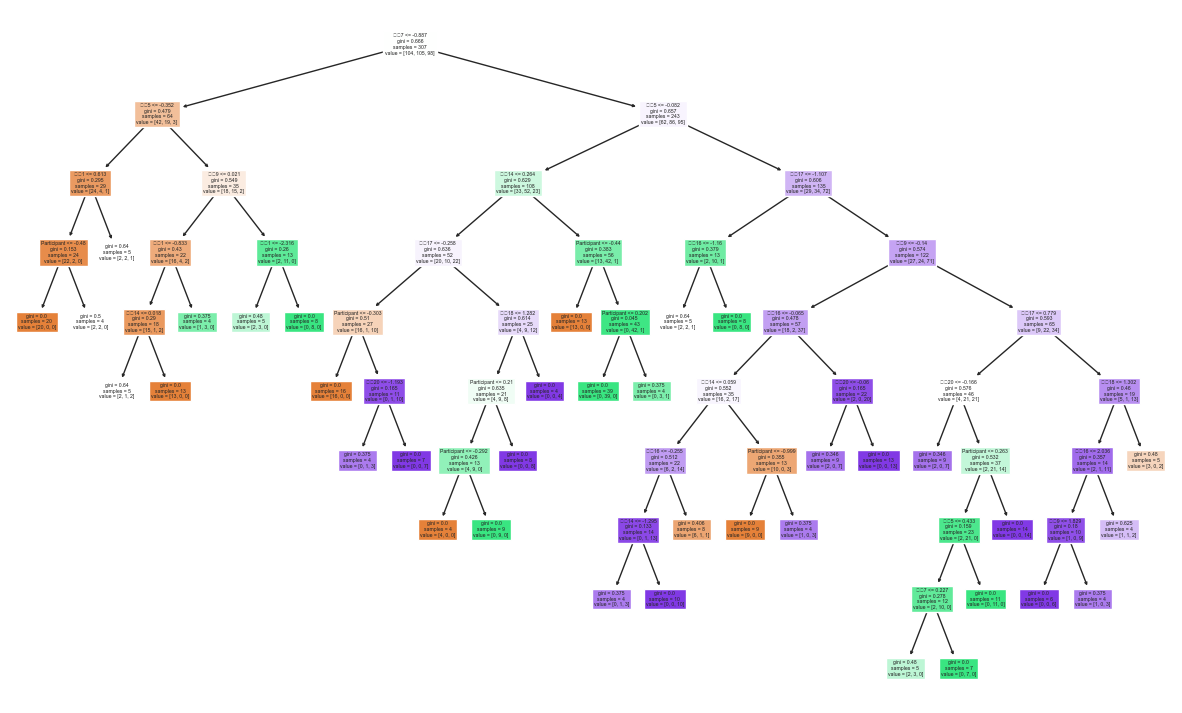

In [74]:
from sklearn import tree
plt.figure(figsize=(15,9))
tree.plot_tree(btree,filled=True,feature_names=X_train.columns)

## 特征重要性

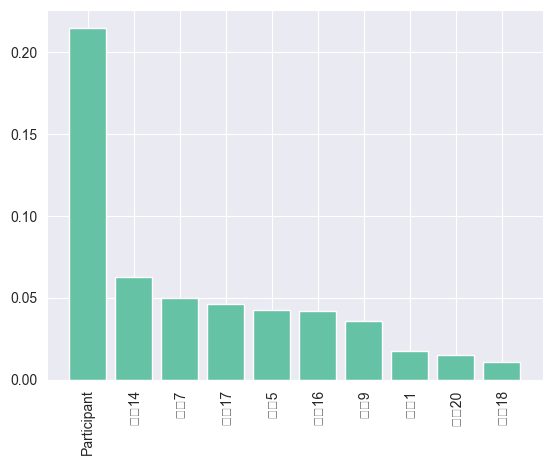

In [75]:
fea_value = btree.tree_.compute_feature_importances(normalize=False)
fea_df = pd.DataFrame()
fea_df['features'] = X_test.columns
fea_df['features_importance'] = fea_value
fea_df.sort_values(by='features_importance',ascending=False,inplace=True)

#绘制条形图
plt.bar(fea_df['features'],fea_df['features_importance'])
plt.xticks(rotation=90)
plt.show()

In [77]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= btree.predict(X_test)


acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))    
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))    
precision = precision_score(y_test, y_pred,average='macro')
print('精确率为：{}'.format(precision))


Start predicting...
准确率为：0.7402597402597403
召回率为：0.7300724637681159
f1分数为：0.7375513626219443
精确率为：0.7474304447988658


## svm

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
import sklearn.svm as svm

params = {'max_iter':range(100,1000,100) 
          ,'kernel': ['linear', 'rbf']
          , 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
          ,'gamma': [0.001, 0.0001]
           }
model_svm = svm.SVC(kernel="linear" ,decision_function_shape="ovo")
gs_svm = GridSearchCV(estimator=model_svm,param_grid=params,cv=10,n_jobs=4)
gs_svm.fit(X_train, y_train.astype('int').values)
print('最好的参数设置为：')
print(gs_svm.best_params_)
bsvm = gs_svm.best_estimator_
bsvm = bsvm.fit(X_train,  y_train.astype('int'))


最好的参数设置为：
{'C': 10, 'gamma': 0.001, 'kernel': 'linear', 'max_iter': 600}


In [68]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= bsvm.predict(X_test)


acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))    
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))    
precision = precision_score(y_test, y_pred,average='macro')
print('精确率为：{}'.format(precision))


Start predicting...
准确率为：0.961038961038961
召回率为：0.9611111111111111
f1分数为：0.9615569337344562
精确率为：0.9615384615384616


## 贝叶斯

In [79]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
model_nb = model_nb.fit(X_train,  y_train.astype('int'))

In [80]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= bsvm.predict(X_test)


acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))    
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))    
precision = precision_score(y_test, y_pred,average='macro')
print('精确率为：{}'.format(precision))


Start predicting...
准确率为：0.961038961038961
召回率为：0.9611111111111111
f1分数为：0.9615569337344562
精确率为：0.9615384615384616


## gbdt

In [81]:
parameter_space = {
    'n_estimators': range(100, 400, 50),
    #                   'validation_fraction':[i/10.0 for i in range(1,10)],
    'max_features': range(5, 30, 3),
    'max_leaf_nodes': range(2, 7, 1)
}

gbc = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                 learning_rate=0.01, loss='log_loss', max_depth=16,
                                 max_features=None, max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_samples_leaf=0.05, min_samples_split=35,
                                 min_weight_fraction_leaf=0.0, n_estimators=350,
                                 n_iter_no_change=None,
                                 random_state=44, subsample=1.0, tol=0.0001,
                                 validation_fraction=0.1, verbose=0,
                                 warm_start=False)

# 计算最好的参数，如果不需要调参则注释这部分
grid = GridSearchCV(gbc, parameter_space, n_jobs=4, cv=5, verbose=5)
grid.fit(X_train, y_train.astype('int'))
print('最好的参数设置为：')
print(grid.best_params_)
bgbdt = grid.best_estimator_

bgbdt = bgbdt.fit(X_train,  y_train.astype('int'))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
最好的参数设置为：
{'max_features': 5, 'max_leaf_nodes': 2, 'n_estimators': 100}


In [82]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= bsvm.predict(X_test)


acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))    
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))    
precision = precision_score(y_test, y_pred,average='macro')
print('精确率为：{}'.format(precision))


Start predicting...
准确率为：0.961038961038961
召回率为：0.9611111111111111
f1分数为：0.9615569337344562
精确率为：0.9615384615384616


## 特征重要性

In [83]:
imp = bgbdt.feature_importances_.tolist()
col_name = df_end.columns.to_list()
col_name.remove('label')
fea_importance = zip(col_name,imp)
fea_importance = dict(fea_importance)
fea_importance= sorted(fea_importance.items(), key=lambda d:d[1], reverse = True)
print('特征重要性为:')
fea_importance

特征重要性为:


[('Participant', 0.8463271942025474),
 ('指标14', 0.09241848796989448),
 ('指标7', 0.029401672840653655),
 ('指标20', 0.020590732630847628),
 ('指标18', 0.006425744909662615),
 ('指标5', 0.0031351122781255606),
 ('指标17', 0.0008129265849349899),
 ('指标16', 0.0004558995879376209),
 ('指标1', 0.0004322289953960985),
 ('指标9', 0.0)]

## dnn

In [87]:
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

In [88]:
class Mydata(Dataset):
    def __init__(self,data):
        self.df = data.values
    def __getitem__(self,idx):
        features = self.df[idx,:-1]
        label    = self.df[idx,-1]
        return features,label
    def __len__(self):
        data_lens = self.df.shape[0]
        return data_lens

# 自定义三层神经网络，由于特征有限，且大部分特征为0，如果定义太多层神经网络，可能导致模型无法收敛
class GeneModel(nn.Module):
    def __init__(self,n_feature,n_hidden,n_output,dropout=0.5):
        super(GeneModel, self).__init__()

        self.input_layer = nn.Linear(n_feature, n_hidden)
        self.bn_layer1 = nn.BatchNorm1d(n_hidden)

        self.hidden_layer1 = nn.Linear(n_hidden,n_hidden//2)
        self.bn_layer2 = nn.BatchNorm1d(n_hidden//2)

        self.output_layer = nn.Linear(n_hidden//2,n_output)
    def forward(self,input):
        x = self.input_layer(input)
        x = F.relu(x)
        x = self.hidden_layer1(x)
        x = F.relu(self.bn_layer2(x))
        x = self.output_layer(x)
#         out = F.softmax(x,dim=1)
        return x

#模型训练过程
def train_loop(dataloader,model,loss_fn,optimizer,t):
    size = len(dataloader.dataset)
    for batch,(x,y) in enumerate(dataloader):
        x = x.to(torch.float32)
        pred = model(x)
        temp =  torch.Tensor([i.argmax() for i in pred])
        loss = loss_fn(pred,y.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
# 模型测试过程
def test_loop(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    num_batchs = len(dataloader)
    test_loss,correct = 0,0
    with torch.no_grad():
        for x,y in dataloader:
            x = x.to(torch.float32)
            pred = model(x)
            test_loss += loss_fn(pred,y.long()).item()
            correct += (pred.argmax(1) == y.long()).type(torch.float).sum().item()

    test_loss /= num_batchs
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [89]:
train_data = X_train
train_data['label'] = y_train
test_data = X_test
test_data['label'] = y_test

train_Dataset = Mydata(train_data)
test_Dataset = Mydata(test_data)
train_dataloader = DataLoader(train_Dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_Dataset, batch_size=8, shuffle=True)
# 2. 模型定义
n_feature = df_end.shape[1] - 1 #特征个数
n_hidden = 200   #隐藏层的神经元自己随意设置，可调
n_output = len(df_end['label'].unique())    #由于是四分类，所以输出是4,不可调
model = GeneModel(n_feature,n_hidden,n_output)

# 3.模型训练
#   3.1超参设置
learning_rate = 1e-3
epochs = 100
#   3.2.设置损失函数和优化函数
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

#   3.3.开始训练
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,t)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.220708  [    0/  307]
Test Error: 
 Accuracy: 45.5%, Avg loss: 1.066470 

Epoch 2
-------------------------------
loss: 0.959002  [    0/  307]
Test Error: 
 Accuracy: 50.6%, Avg loss: 1.002333 

Epoch 3
-------------------------------
loss: 1.160310  [    0/  307]
Test Error: 
 Accuracy: 58.4%, Avg loss: 0.918130 

Epoch 4
-------------------------------
loss: 0.864130  [    0/  307]
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.855336 

Epoch 5
-------------------------------
loss: 0.744772  [    0/  307]
Test Error: 
 Accuracy: 64.9%, Avg loss: 0.871607 

Epoch 6
-------------------------------
loss: 0.707975  [    0/  307]
Test Error: 
 Accuracy: 75.3%, Avg loss: 0.782491 

Epoch 7
-------------------------------
loss: 0.719634  [    0/  307]
Test Error: 
 Accuracy: 75.3%, Avg loss: 0.727887 

Epoch 8
-------------------------------
loss: 0.803297  [    0/  307]
Test Error: 
 Accuracy: 71.4%, Avg loss: 0.729430 

Epoch 9
----------------

Test Error: 
 Accuracy: 79.2%, Avg loss: 0.451602 

Epoch 69
-------------------------------
loss: 0.176854  [    0/  307]
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.430442 

Epoch 70
-------------------------------
loss: 0.231054  [    0/  307]
Test Error: 
 Accuracy: 74.0%, Avg loss: 0.599437 

Epoch 71
-------------------------------
loss: 0.140985  [    0/  307]
Test Error: 
 Accuracy: 89.6%, Avg loss: 0.386563 

Epoch 72
-------------------------------
loss: 0.285008  [    0/  307]
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.623739 

Epoch 73
-------------------------------
loss: 0.202952  [    0/  307]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.424162 

Epoch 74
-------------------------------
loss: 0.282028  [    0/  307]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.398334 

Epoch 75
-------------------------------
loss: 0.180996  [    0/  307]
Test Error: 
 Accuracy: 92.2%, Avg loss: 0.357935 

Epoch 76
-------------------------------
loss: 0.633156  [    0/  307]
Test Error: 
 Ac

In [90]:
feature = test_data.drop('label',axis=1)
feature = torch.Tensor(feature.values)
label = test_data['label']
model.eval()
pred_tmp = model(feature)
data = pred_tmp.detach().numpy()
y_pred_prob = data[:,1]
y_pred = [i.argmax() for i in data]

acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))    
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))    
precision = precision_score(y_test, y_pred,average='macro')
print('精确率为：{}'.format(precision))

准确率为：0.8831168831168831
召回率为：0.8855072463768116
f1分数为：0.8868157897807494
精确率为：0.8952380952380952


## 重写dnn(加入embedding层)

In [91]:
def sparsFeature(feat, feat_num, embed_dim=4):
    """
    create dictionary for sparse feature
    :param feat: feature_name
    :param feat_num: the total number of sparse features that do not repeat
    :param embed_dim: embedding dimension
    :return
    """
    return {'feat': feat, 'feat_num': feat_num, 'embed_dim': embed_dim}

def denseFeature(feat):
    """
    create dictionary for dense feature
    :param feat: dense feature name
    : return
    """
    return {'feat': feat}

In [92]:
class Dnn(nn.Module):
    """
    Dnn part
    """
    def __init__(self, hidden_units,dropout=0.):
        """
        hidden_units: 列表， 每个元素表示每一层的神经单元个数， 比如[256, 128, 64], 两层网络， 第一层神经单元128， 第二层64， 第一个维度是输入维度
        dropout: 失活率
        """
        super(Dnn, self).__init__()
        
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p=dropout)
#         self.output_layer = nn.Linear(hidden_units[-1],n_output)
    
    def forward(self, x):
        
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)
#         x = self.output_layer(x)
        x = self.dropout(x)
        return x

In [93]:
class WideDeep(nn.Module):
    def __init__(self, feature_columns, hidden_units, n_output,dnn_dropout=0.):
        super(WideDeep, self).__init__()
        self.sparse_feature_cols = feature_columns
        # embedding 
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
            for i, feat in enumerate(self.sparse_feature_cols)
        })
        
        hidden_units.insert(0, len(self.sparse_feature_cols)*self.sparse_feature_cols[0]['embed_dim'])
        hidden_units.append(n_output)
        self.dnn_network = Dnn(hidden_units)
    
    def forward(self, x):
        sparse_inputs = x
        sparse_inputs = sparse_inputs.long()
        sparse_embeds = [self.embed_layers['embed_'+str(i)](sparse_inputs[:, i]) for i in range(sparse_inputs.shape[1])]
        sparse_embeds = torch.cat(sparse_embeds, axis=-1)
        
        dnn_input = sparse_embeds
        deep_out = self.dnn_network(dnn_input)
                
        deep_out = F.softmax(deep_out)
        
        return deep_out  
#模型训练过程
def train_loop(dataloader,model,loss_fn,optimizer,t):
    size = len(dataloader.dataset)
    for batch,(x,y) in enumerate(dataloader):
        x = x.to(torch.float32)
        pred = model(x)
        temp =  torch.Tensor([i.argmax() for i in pred])
        loss = loss_fn(pred,y.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
# 模型测试过程
def test_loop(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    num_batchs = len(dataloader)
    test_loss,correct = 0,0
    with torch.no_grad():
        for x,y in dataloader:
            x = x.to(torch.float32)
            pred = model(x)
            test_loss += loss_fn(pred,y.long()).item()
            correct += (pred.argmax(1) == y.long()).type(torch.float).sum().item()

    test_loss /= num_batchs
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [94]:
# 可调超参数：hidden_units、learning_rate、epochs
sparse_feas = df_end.columns.to_list()
sparse_feas.remove('label')
embed_dim = 2
feature_columns = [sparsFeature(feat, len(df_end[feat].unique()), embed_dim=embed_dim) for feat in sparse_feas]


# 建立模型
hidden_units = [64, 32, 16]
dnn_dropout = 0.
n_output = len(df_end['label'].unique())    #由于是四分类，所以输出是4,不可调
model1 = WideDeep(feature_columns, hidden_units,n_output, dnn_dropout)

# 3.模型训练
#   3.1超参设置
learning_rate = 0.1
epochs = 1000
#   3.2.设置损失函数和优化函数
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model1.parameters(),lr=learning_rate)

#   3.3.开始训练
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_dataloader, model1, loss_fn1, optimizer1,t)
    test_loop(test_dataloader, model1, loss_fn1)
print("Done!")

Epoch 1
-------------------------------


IndexError: index out of range in self